In [1]:
import deepchem as dc
import numpy as np
import tensorflow as tf

/Users/danieldemarchi/anaconda3/envs/deepchem/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/Users/danieldemarchi/anaconda3/envs/deepchem/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
n_classes = 4
class_centers = np.random.uniform(-4, 4, (n_classes, 2))
class_transforms = []
for i in range(n_classes):
    xscale = np.random.uniform(0.5, 2)
    yscale = np.random.uniform(0.5, 2)
    angle = np.random.uniform(0, np.pi)
    m = [[xscale*np.cos(angle), -yscale*np.sin(angle)],
         [xscale*np.sin(angle), yscale*np.cos(angle)]]
    class_transforms.append(m)
class_transforms = np.array(class_transforms)

In [3]:
def generate_data(n_points):
    classes = np.random.randint(n_classes, size=n_points)
    r = np.random.random(n_points)
    angle = 2*np.pi*np.random.random(n_points)
    points = (r*np.array([np.cos(angle), np.sin(angle)])).T
    points = np.einsum('ijk,ik->ij', class_transforms[classes], points)
    points += class_centers[classes]
    return classes, points

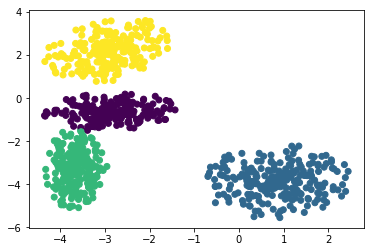

In [4]:
%matplotlib inline
import matplotlib.pyplot as plot
classes, points = generate_data(1000)
plot.scatter(x=points[:,0], y=points[:,1], c=classes)

In [5]:
import deepchem.models.tensorgraph.layers as layers
model = dc.models.TensorGraph(learning_rate=1e-3, use_queue=False)

# Inputs to the model

random_in = layers.Feature(shape=(None, 10)) # Random input to the generator
generator_classes = layers.Feature(shape=(None, n_classes)) # The classes of the generated samples
real_data_points = layers.Feature(shape=(None, 2)) # The training samples
real_data_classes = layers.Feature(shape=(None, n_classes)) # The classes of the training samples
is_real = layers.Weights(shape=(None, 1)) # Flags to distinguish real from generated samples

# The generator

gen_in = layers.Concat([random_in, generator_classes])
gen_dense1 = layers.Dense(30, in_layers=gen_in, activation_fn=tf.nn.relu)
gen_dense2 = layers.Dense(30, in_layers=gen_dense1, activation_fn=tf.nn.relu)
generator_points = layers.Dense(2, in_layers=gen_dense2)
model.add_output(generator_points)

# The discriminator

all_points = layers.Concat([generator_points, real_data_points], axis=0)
all_classes = layers.Concat([generator_classes, real_data_classes], axis=0)
discrim_in = layers.Concat([all_points, all_classes])
discrim_dense1 = layers.Dense(30, in_layers=discrim_in, activation_fn=tf.nn.relu)
discrim_dense2 = layers.Dense(30, in_layers=discrim_dense1, activation_fn=tf.nn.relu)
discrim_prob = layers.Dense(1, in_layers=discrim_dense2, activation_fn=tf.sigmoid)

In [6]:
# Discriminator

discrim_real_data_loss = -layers.Log(discrim_prob+1e-10) * is_real
discrim_gen_data_loss = -layers.Log(1-discrim_prob+1e-10) * (1-is_real)
discrim_loss = layers.ReduceMean(discrim_real_data_loss + discrim_gen_data_loss)
discrim_submodel = model.create_submodel(layers=[discrim_dense1, discrim_dense2, discrim_prob], loss=discrim_loss)

# Generator

gen_loss = -layers.ReduceMean(layers.Log(discrim_prob+1e-10) * (1-is_real))
gen_submodel = model.create_submodel(layers=[gen_dense1, gen_dense2, generator_points], loss=gen_loss)

In [7]:
batch_size = model.batch_size
discrim_error = []
gen_error = []
for step in range(30000):
    classes, points = generate_data(batch_size)
    class_flags = dc.metrics.to_one_hot(classes, n_classes)
    feed_dict={random_in: np.random.random((batch_size, 10)),
               generator_classes: class_flags,
               real_data_points: points,
               real_data_classes: class_flags,
               is_real: np.concatenate([np.zeros((batch_size,1)), np.ones((batch_size,1))])}
    discrim_error.append(model.fit_generator([feed_dict],
                                             submodel=discrim_submodel,
                                             checkpoint_interval=0))
    if step%2 == 0:
        gen_error.append(model.fit_generator([feed_dict],
                                             submodel=gen_submodel,
                                             checkpoint_interval=0))
    if step%1000 == 999:
        print(step, np.mean(discrim_error), np.mean(gen_error))
        discrim_error = []
        gen_error = []

999 0.5351033435612917 0.5078269869685174
1999 0.6795710835456849 0.4263230015039444
2999 0.6723129698336124 0.4446150112748146
3999 0.6585501898229122 0.4580318982601166
4999 0.679729451328516 0.4682509544491768
5999 0.6799016329944134 0.4745054561495781
6999 0.6737360445857048 0.5017610773444175
7999 0.6733076794445515 0.5029943257570266
8999 0.6740219102501869 0.551674585044384
9999 0.6846181039214134 0.5211825024485588
10999 0.6872074206471444 0.5027871658802032
11999 0.6842118120193481 0.530654501080513
12999 0.6876616222858429 0.5494909217357635
13999 0.7011651927232743 0.5305739033818245
14999 0.691092293381691 0.542425560951233
15999 0.6749733729660511 0.5677198895215988
16999 0.6561786183118821 0.5952875652909279
17999 0.687408155798912 0.5225949524641037
18999 0.6900106729269028 0.5302275929450989
19999 0.6828228008449078 0.5804300701022148
20999 0.6828730189204216 0.5947452707886696
21999 0.7023218905925751 0.5054486514925957
22999 0.6916027978658676 0.5525911054611206
23999

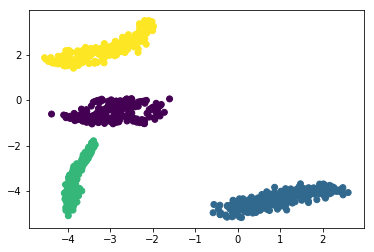

In [8]:
classes, points = generate_data(1000)
feed_dict = {random_in: np.random.random((1000, 10)),
             generator_classes: dc.metrics.to_one_hot(classes, n_classes)}
gen_points = model.predict_on_generator([feed_dict])
plot.scatter(x=gen_points[:,0], y=gen_points[:,1], c=classes)